In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance,XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Caricamento dati ===
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [3]:

# === pulizia valori nulli ===
train_df = train_df.dropna()
test_df = test_df.dropna()

# Mappa dei valori
weight_map = {
    'Normal_Weight': 1,
    'Insufficient_Weight': 0,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

# Applicazione della mappa
train_df['NObeyesdad'] = train_df['NObeyesdad'].map(weight_map)

# === 3. Encoding yes/no → True/False ===
for df in [train_df, test_df]:
    df.replace({'yes': True, 'no': False}, inplace=True)

# === 4. Encoding delle colonne categoriche (esclusa la colonna target) ===
categorical_cols = train_df.select_dtypes(include='object').columns

label_encoders = {}
common_categorical_cols = [col for col in categorical_cols if col in test_df.columns]
le = LabelEncoder()
for col in common_categorical_cols:
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = test_df[col].astype(str)
    test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else 'unknown')
    le.classes_ = np.append(le.classes_, 'unknown') if 'unknown' not in le.classes_ else le.classes_
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le
    
exclusive_train_cols = [col for col in categorical_cols if col not in test_df.columns]
for col in exclusive_train_cols:
    train_df[col] = le.fit_transform(train_df[col].astype(str))

# === 5. Separazione input/target ===
X = train_df.drop(columns=['id', 'NObeyesdad'])  # Rimuovi anche 'id' se non è utile per il modello
y = train_df['NObeyesdad']


# === 6. Divisione in train e validation ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\filip\AppData\Local\Temp\ipykernel_12544\2593740499.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'yes': True, 'no': False}, inplace=True)


In [10]:
# === 7. Feature selection (opzionale, basata su VIF e p-value) ===
def calculate_vif(X):
    # Assicura solo colonne numeriche e converte bool in int
    X_numeric = X.select_dtypes(include=[np.number, 'bool']).copy()
    X_numeric = X_numeric.astype(float)
    
    # Rimuove eventuali infiniti
    X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_numeric.dropna(inplace=True)
    
    return pd.DataFrame({
        'feature': X_numeric.columns,
        'VIF': [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
    })

def calculate_pvalues(X, y):
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    return model.pvalues[1:]  # exclude intercept

def feature_selection(X, y, vif_threshold=10, pval_threshold=0.05):
    while True:
        vif = calculate_vif(X)
        pvals = calculate_pvalues(X, y)

        drop_cols = [
            col for col in X.columns
            if vif[vif.feature == col]['VIF'].values[0] > vif_threshold or pvals[col] > pval_threshold
        ]

        if not drop_cols:
            break

        print(f"Rimosse feature: {drop_cols}")
        X = X.drop(columns=drop_cols)

    return X


In [5]:
# === 8. Normalizzazione ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test = test_df.drop(columns=['id', 'NObeyesdad'], errors='ignore')
X_test_scaled = scaler.transform(X_test)

In [6]:


X_train_selected = X_train.copy() #====feature_selection(X_train.copy(), y_train)

# === Verifica e gestione dei valori nulli in y_train ===
if y_train.isnull().sum() > 0:
    print(f"Valori mancanti in y_train: {y_train.isnull().sum()}")
    # Rimuovi le righe con valori mancanti
    # non_null_indices = y_train.notnull()
    # X_train_selected = X_train_selected[non_null_indices]
    # y_train = y_train[non_null_indices]


# === Modello con XGBoost e GridSearchCV ===
# Definisci i parametri per la ricerca a griglia
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Inizializza il modello XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Configura GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Addestra il modello
grid_search.fit(X_train_selected, y_train)

# Stampa i migliori parametri trovati
print(f"Migliori parametri trovati: {grid_search.best_params_}")

# Usa il miglior modello per fare predizioni
best_model = grid_search.best_estimator_

# === Preparazione del test set ===
X_test = test_df.drop(columns=['id', 'NObeyesdad'], errors='ignore')  # Rimuovi 'id' e 'NObeyesdad' se presenti
X_test_selected = X_test[X_train_selected.columns]  # Allinea le colonne con quelle selezionate nel train

# Predizioni
predictions = best_model.predict(X_test_selected)
predictions = np.clip(predictions, 0, 6).astype(int)  # blocca fuori range

# Inverti l'encoding per avere le etichette leggibili
inverse_map = {v: k for k, v in weight_map.items()}
pred_labels = [inverse_map.get(p, 'Unknown') for p in predictions]

# Crea un DataFrame con gli ID e le predizioni
output = test_df[['id']].copy()
output['Predicted_Obesity_Level'] = pred_labels

# Salvataggio su CSV
output.to_csv("C:/Users/Ciro/Desktop/CorsoPython/pythonProgettiGruppo/PredizioneDellObesita/Dati/predizioni_obesita.csv", index=False)

# Mostra le prime 10 predizioni
print("📊 Prime 10 predizioni sul test set:")
print(output.head(10))




Fitting 3 folds for each of 54 candidates, totalling 162 fits


c:\Users\Ciro\Desktop\CorsoPython\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:05:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ciro\Desktop\CorsoPython\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:05:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ciro\Desktop\CorsoPython\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:05:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ciro\Desktop\CorsoPython\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:05:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Paramet

Migliori parametri trovati: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
📊 Prime 10 predizioni sul test set:
      id Predicted_Obesity_Level
0  20758         Obesity_Type_II
1  20759      Overweight_Level_I
2  20760        Obesity_Type_III
3  20761          Obesity_Type_I
4  20762        Obesity_Type_III
5  20763     Insufficient_Weight
6  20764     Insufficient_Weight
7  20765           Normal_Weight
8  20766     Overweight_Level_II
9  20767           Normal_Weight


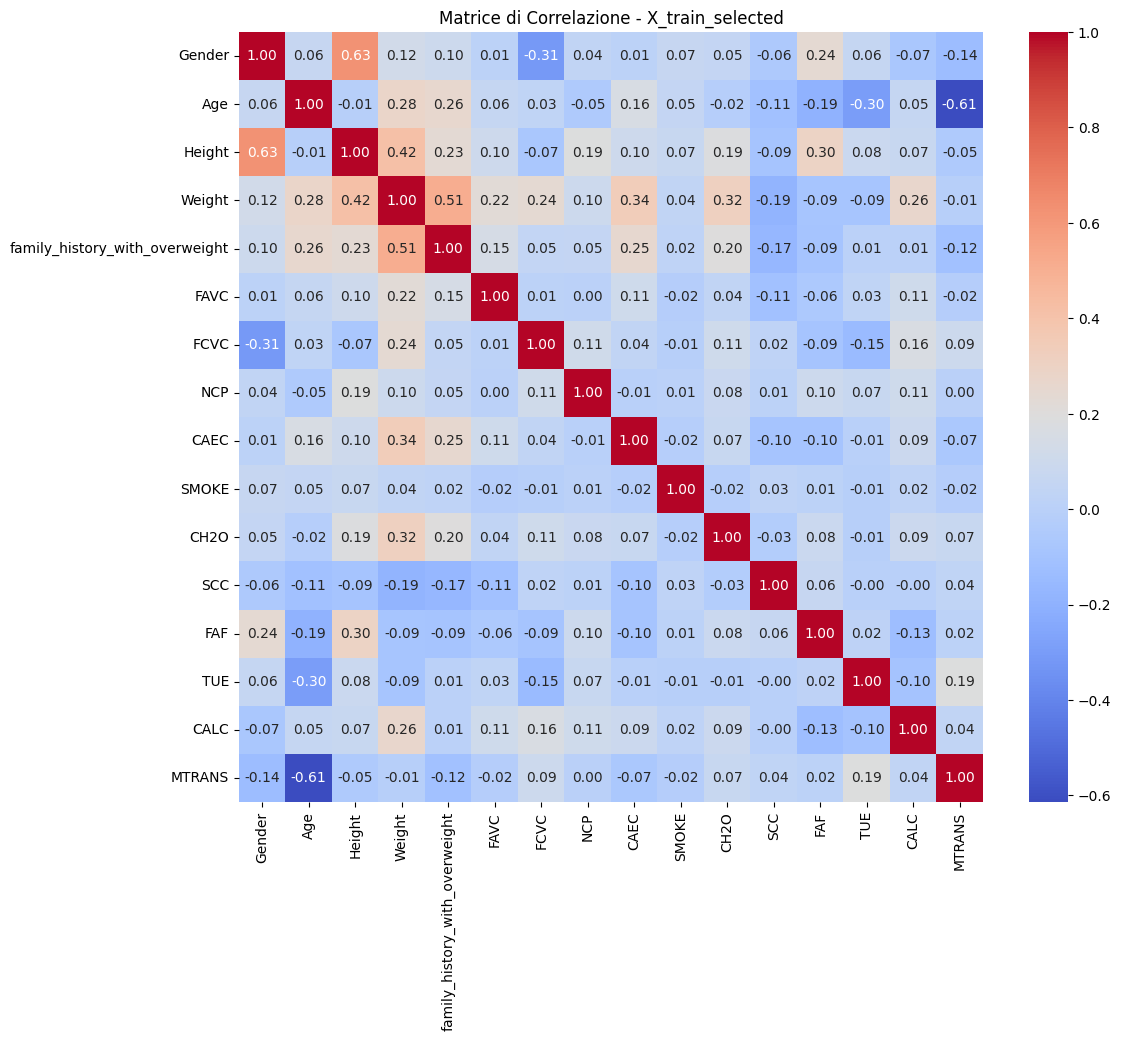

In [7]:


# Calcola la matrice di correlazione
correlation_matrix = X_train_selected.corr()

# Crea una heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Titolo della heatmap
plt.title("Matrice di Correlazione - X_train_selected")
plt.show()

In [8]:
import joblib

joblib.dump(best_model, 'xgb_obesity_model.pkl')     # salva il modello
joblib.dump(scaler, 'scaler.pkl')                    # salva lo scaler
joblib.dump(inverse_map, 'inverse_map.pkl')          # salva mappa numeri → classi
joblib.dump(le, 'label_encoder.pkl')  # per la variabile target

['label_encoder.pkl']